In [ ]:
# TODO Monday 10/14 
# Show model bias (e.g., a constant model) impacts the PR curve for a given x-bin more as the variance in x in the x-bin increases, 
# until you get to the limiting case where the x-bin encompasses the entire range of x values, and the PR curve is the same as the overall PR curve.
# Basically, auPRC increases as (1) model complexity increases and (2) the signal-to-noise ratio increases.
# Thus, there are three dimensions to the problem: model complexity (rows in plot below), signal-to-noise ratio (x-bins in the plot below), and bin-width (columns in the plot below), 
# which exposes the inadequacy of a given model as the bin-width increases.


## Sample from a feature distribution (mimicking GC content, the length of a genomic interval, etc)

Text(0, 0.5, 'number of examples')

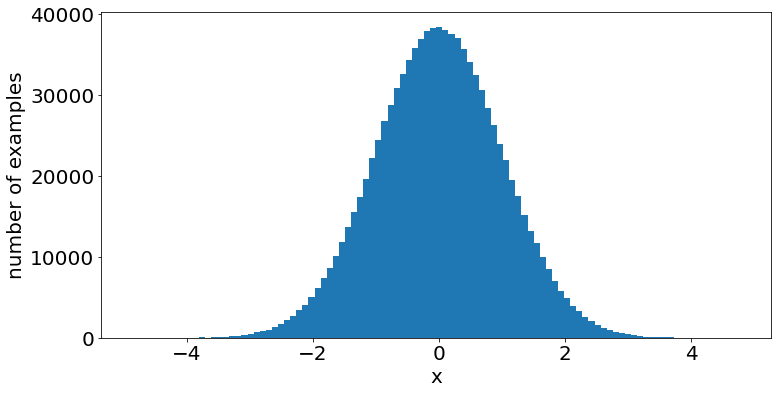

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})

NUMBER_EXAMPLES = 1000000 # Number of intervals

# Sample from a univariate normal distribution
MEAN = 0
STD = 1
xs = np.random.normal(loc=MEAN, scale=STD, size=NUMBER_EXAMPLES)

plt.figure(figsize=(12, 6))
plt.hist(xs, bins=100)
plt.xlabel('x')
plt.ylabel('number of examples')

## True mapping from feature to target (mimicking SNV counts)

Text(0, 0.5, 'number of examples')

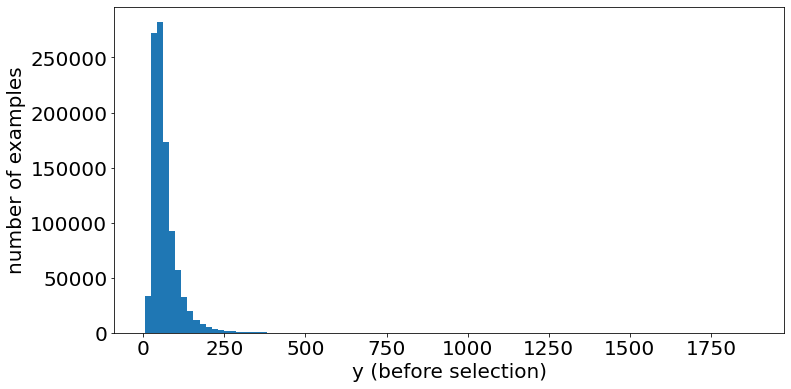

In [96]:
# parameters of true model 
A = 4
B = 0.5 
C = 0.05

TRUE_RATE = lambda x: np.exp(A + B*x + C*x**2) # rate function

ys = np.random.poisson(lam=TRUE_RATE(xs)) # target 

plt.figure(figsize=(12, 6))
plt.hist(ys, bins=100)
plt.xlabel('y (before selection)')
plt.ylabel('number of examples')

## Introduce selection into a small fraction of examples

In [97]:
# Take x% of the examples, declare them to be positive examples, and reduce their y values (possibly in proportion to x), 
# to mimic the effect of negative selection (and how it is stronger in regions with higher GC content, e.g., genes)

# Take the remaining examples, declare them to be neutral (negative) examples, and do not change their y values

POSITIVE_FRACTION = 0.2

num_pos = int(POSITIVE_FRACTION*NUMBER_EXAMPLES)

# FRACTIONAL_REDUCTION_IN_Y = 0.2
# x_factor = (xs - xs.min()) / (xs.max() - xs.min())
# y_pos = ys[:num_pos] * (1 - FRACTIONAL_REDUCTION_IN_Y * x_factor[:num_pos])

Y_DEPLETION = 10
y_pos = np.maximum(0, ys[:num_pos] - Y_DEPLETION)

y_neg = ys[num_pos:]
ys = np.concatenate([y_pos, y_neg])

constrained = num_pos*[True] + (NUMBER_EXAMPLES-num_pos)*[False]

DATA = pd.DataFrame({'x': xs, 'y': ys, 'constrained': constrained})
DATA

,x,y,constrained
0,-0.659608,40,True
1,1.104735,87,True
2,0.346428,54,True
3,-0.408573,40,True
4,0.793756,58,True
...,...,...,...
999995,-1.094906,31,False
999996,-0.267695,52,False
999997,-1.458224,28,False
999998,-0.194064,58,False


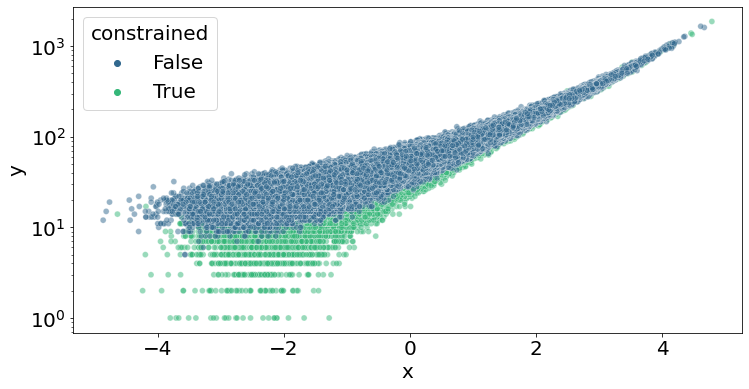

In [98]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(data=DATA, x='x', y='y', hue='constrained', palette='viridis', alpha=0.5)
plt.yscale('log')

## Fit neutral models and stratify their performances by x

Optimization terminated successfully.
         Current function value: 13.830713
         Iterations 1
Optimization terminated successfully.
         Current function value: 13.830713
         Iterations 1
Optimization terminated successfully.
         Current function value: 13.830713
         Iterations 1
Optimization terminated successfully.
         Current function value: 3.630999
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.630999
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.630999
         Iterations 5


<ipython-input-99-17578baab16b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['x2'] = data_neg['x']**2


Optimization terminated successfully.
         Current function value: 3.442355
         Iterations 7


<ipython-input-99-17578baab16b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['x2'] = data_neg['x']**2


Optimization terminated successfully.
         Current function value: 3.442355
         Iterations 7


<ipython-input-99-17578baab16b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['x2'] = data_neg['x']**2


Optimization terminated successfully.
         Current function value: 3.442355
         Iterations 7


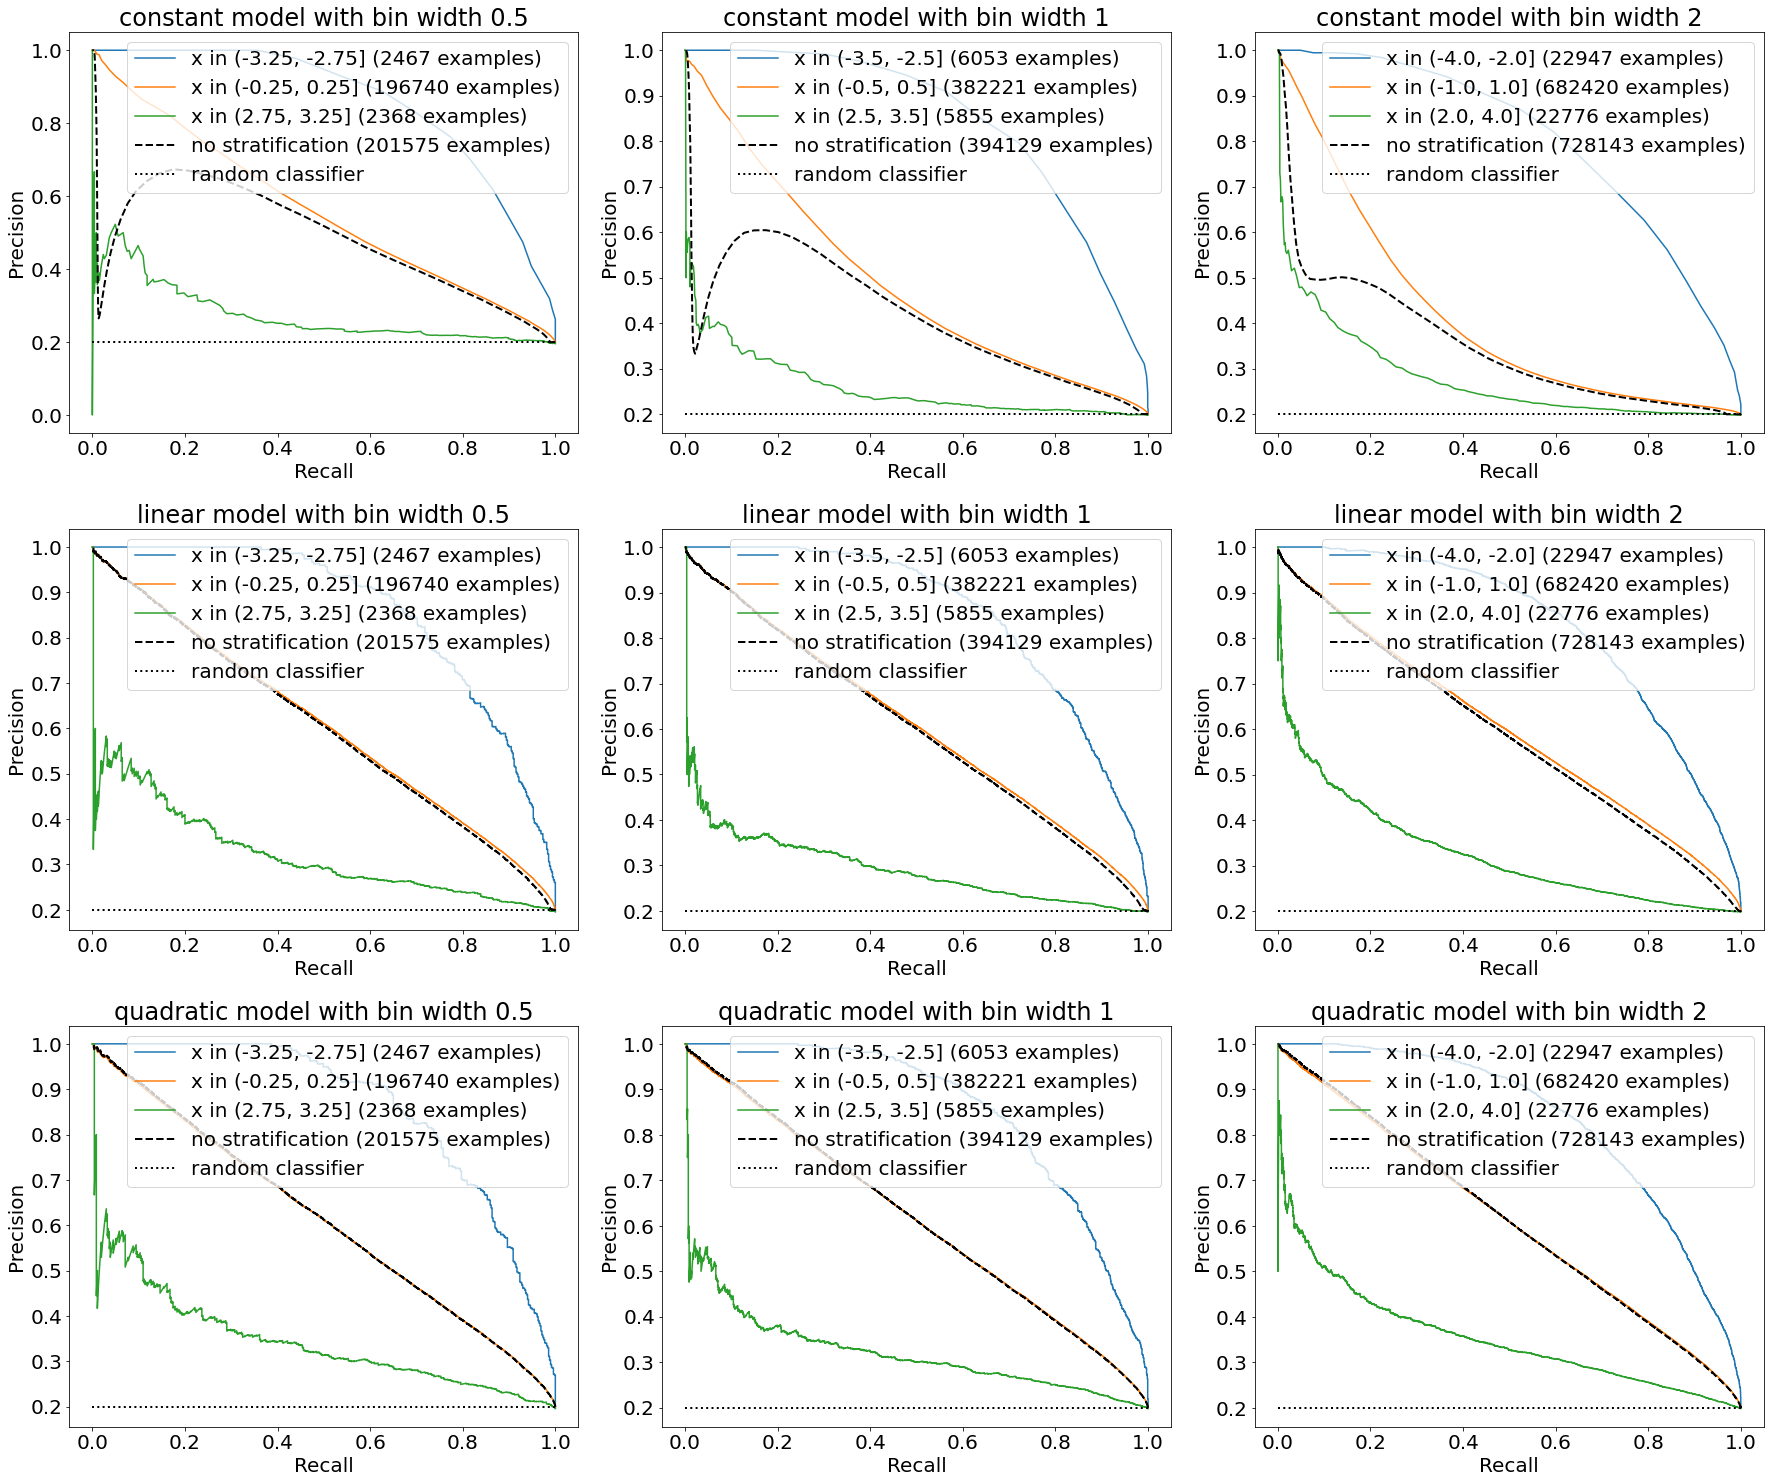

In [99]:
import statsmodels.api as sm

def fit_poisson_model(df, model_type):
    data = df

    data_neg = data[data['constrained'] == 0]

    if model_type == 'constant':
        x_model_neg = np.ones((data_neg.shape[0], 1))
        x_model = np.ones((data.shape[0], 1))  
    elif model_type == 'linear':
        x_model_neg = sm.add_constant(data_neg['x'])
        x_model = sm.add_constant(data['x'])
    elif model_type == 'quadratic':
        data_neg['x2'] = data_neg['x']**2
        x_model_neg = sm.add_constant(data_neg[['x', 'x2']])
        data['x2'] = data['x']**2
        x_model = sm.add_constant(data[['x', 'x2']])
    else:
        raise ValueError(f"Unknown model type: {model_type}")
            
    model = sm.Poisson(data_neg['y'], x_model_neg).fit()
    # print(model.params)

    data[f'predicted_y_model'] = model.predict(x_model)

    data['residuals_model'] = data[f'predicted_y_model'] - data['y']
    data[f'standardized_residuals_model'] = (
        data[f'predicted_y_model'] - data['y'] 
    ) / np.sqrt(data[f'predicted_y_model'])
        
    return data

def plot_y(df, constrained):
    df = df[df['constrained'] == constrained]

    x_ = np.linspace(df['x'].min(), df['x'].max(), 100)
    y_ = TRUE_RATE(x_)

    plt.figure(figsize=(12, 6))
    plt.plot(df['x'], df['y'], 'o', alpha=0.5, label='y')
    plt.plot(df['x'], df['predicted_y_model'], 'o', label='Learned rate')
    plt.plot(x_, y_, label='True rate', color='black')
    plt.yscale('log')
    plt.xlabel('x')
    plt.title(f'Constrained = {constrained}')
    plt.legend()
    plt.xlim(-5, 5)
    plt.ylim(1, 1e3)

def plot_residuals(df, constrained, standardized, ylim):
    df = df[df['constrained'] == constrained].copy()

    df[f'x_bin_midpoints'] = (pd
        .cut(df['x'], bins=20, labels=None)
        .apply(lambda x: (x.right + x.left) / 2)
    )

    if standardized:
        residuals_label = 'standardized_residuals_model'
    else:
        residuals_label = 'residuals_model'

    average_residual = df.groupby(f'x_bin_midpoints')[residuals_label].mean()  

    plt.figure(figsize=(10, 6))
    plt.scatter(df['x'], df[residuals_label], alpha=0.7, label=residuals_label)
    plt.plot(average_residual.index, average_residual.values, color='red', lw=2, label=f'mean {residuals_label}') 

    if not standardized: 
        x = np.linspace(df['x'].min(), df['x'].max(), 100)
        if not constrained:
            y_exp = np.sqrt(TRUE_RATE(x))
            plt.plot(x, y_exp, color='black', lw=2, label=f'envelope (expected)')

            y_obs = df.groupby(f'x_bin_midpoints')[residuals_label].std()
            plt.plot(y_obs.index, y_obs.values, color='green', lw=2, label=f'envelope (observed)')
        else:  # TODO: 
            pass
            # y_exp = Y_DEPLETION + np.sqrt(TRUE_RATE(x))
            # plt.plot(x, y_exp, color='black', lw=2, label=f'envelope (expected)')

            # y_obs = df.groupby(f'x_bin_midpoints')[residuals_label].std()
            # y_obs = Y_DEPLETION + y_obs
            # plt.plot(y_obs.index, y_obs.values, color='green', lw=2, label=f'envelope (observed)')

    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel('x')
    plt.xlim(-5, 5)
    plt.ylim(ylim)

    # if constrained:
    #     x_ = np.linspace(df['x'].min(), df['x'].max(), 100)
    #     mu = TRUE_RATE(x_)
    #     sigma = np.sqrt(mu)
    #     y_ = Y_DEPLETION / sigma # this depends on how selection affects y values
    #     plt.plot(x_, y_, color='black', lw=2, label='expected mean')

    plt.legend()

import seaborn as sns
from matplotlib.patches import Patch

NUMBER_EXAMPLES_MIN = 100

def normal_distribution(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def plot_residual_distributions(df, standardized, xlim):
    groups = df.groupby('x_bin')
    filtered_groups = {x_bin: group for x_bin, group in groups if len(group) > NUMBER_EXAMPLES_MIN}

    fig, axes = plt.subplots(1, len(filtered_groups), figsize=(6 * len(filtered_groups), 6), sharey=True)

    xlabel = 'standardized_residuals_model' if standardized else 'residuals_model'    
    bins = np.linspace(xlim[0], xlim[1], 100) 
        
    for i, (x_bin, group) in enumerate(filtered_groups.items()):        
        ax = axes[i] 

        bin_centers = (bins[1:] + bins[:-1]) / 2
        bin_width = bins[1] - bins[0]

        palette = {False: 'blue', True: 'orange'}
        alpha = 0.5  

        sns.histplot(
            data=group, 
            x=xlabel, 
            hue='constrained', 
            kde=False, 
            element='step', 
            bins=bins, 
            ax=ax, 
            palette=palette, 
            alpha=alpha
        )

        # Calculate mean (lambda)
        lambda_ = group[group['constrained'] == False]['y'].mean()

        # Plot normal distribution
        x = bin_centers
        if standardized:
            y = normal_distribution(x, mu=0, sigma=1)
        else:
            y = normal_distribution(x, mu=0, sigma=np.sqrt(lambda_))            
        negative_class_count = len(group[group['constrained'] == False])
        y_scaled = y * negative_class_count * bin_width  
        normal_line, = ax.plot(x, y_scaled, color='red', lw=2)

        ax.set_xlabel(xlabel)
        ax.set_ylabel('number of examples')
        ax.set_title(f'x in {x_bin}')
        ax.set_yscale('log')  
        ax.set_xlim(xlim) 
        ax.set_ylim(1, 1e4)

        # Manually create legend handles and labels
        handles = [
            Patch(color=palette[False], alpha=alpha),
            Patch(color=palette[True], alpha=alpha),
            normal_line
        ]
        labels = [
            'Constrained = False', 
            'Constrained = True', 
            'Standard Normal' if standardized else 'Normal'
        ]
        ax.legend(handles=handles, labels=labels)

    plt.show()

def create_bins(bin_width):
    bin_centers = np.array([-3, 0, 3])
    left = bin_centers - bin_width / 2
    right = bin_centers + bin_width / 2
    intervals = list(zip(left, right))
    return pd.IntervalIndex.from_tuples(intervals)

def plot_residual_distributions_wrapper(df):
    plot_residual_distributions(df, standardized=True, xlim=(-10, 10))
    plot_residual_distributions(df, standardized=False, xlim=(-50, 50))

from sklearn.metrics import precision_recall_curve

def plot_pr_curves(ax, df, title):
    groups = df.groupby('x_bin')

    pr_curves = {}
    for x_bin, group in groups:        
        precision, recall, _ = precision_recall_curve(group['constrained'], group[f'standardized_residuals_model'])
        pr_curves[x_bin] = (precision, recall, len(group))

    for x_bin, (precision, recall, num_examples) in pr_curves.items():
        if num_examples > NUMBER_EXAMPLES_MIN:
            ax.plot(recall, precision, label=f'x in {x_bin} ({num_examples} examples)')

    # no stratification
    precision, recall, _ = precision_recall_curve(df['constrained'], df[f'standardized_residuals_model'])
    ax.plot(recall, precision, label=f'no stratification ({len(df)} examples)', color='black', lw=2, linestyle='--')

    ax.plot([0, 1], [POSITIVE_FRACTION, POSITIVE_FRACTION], color='black', lw=2, linestyle=':', label='random classifier')

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.legend()

def f(): 
    model_types = ['constant', 'linear', 'quadratic'] # ['quadratic']
    bin_widths = [0.5, 1, 2] # [1] 
    
    fig, axes = plt.subplots(len(model_types), len(bin_widths), figsize=(25, 7 * len(model_types)))
    
    handles, labels = [], []

    for i, model_type in enumerate(model_types):
        for j, bin_width in enumerate(bin_widths):
            df = DATA.copy()
            df = fit_poisson_model(df, model_type)
            # plot_y(df, constrained=False)
            # plot_y(df, constrained=True)
            # plot_residuals(df, constrained=False, standardized=True, ylim=(-10, 10))
            # plot_residuals(df, constrained=True, standardized=True, ylim=(-10, 10))
            # plot_residuals(df, constrained=False, standardized=False, ylim=(-300, 300))
            # plot_residuals(df,constrained=True, standardized=False, ylim=(-300, 300))

            bins = create_bins(bin_width)
            df['x_bin'] = (pd
                .cut(df['x'], bins=bins, labels=None)
            )
            df = df.dropna(subset=['x_bin'])            
            # plot_residual_distributions_wrapper(df)
            plot_pr_curves(axes[i, j], df, title=f'{model_type} model with bin width {bin_width}')

    plt.tight_layout()
    plt.show()

f()

In [101]:
# TODO 
# compute PR curves using residuals, instead of standardized residuals

In [102]:
# TODO 
# Use simulation 3.2 to do a power analysis, showing that power is low when auPRC is low

In [103]:
# TODO: generalize the code to show all examples in slides: https://docs.google.com/presentation/d/1L2xFxKYLaHPkgvl1lG1eGrV2_zg6eKqcmEEcJWB2wIc/edit#slide=id.g309fa974356_0_7

In [104]:
# TODO 
# 1. stratify not by x, but by TRUE_RATE(x)
# 2. then infer the dependence of depletion on x from the divergence of the PR curves 

# TODO (related) 
# siepel has already inferred depletion (lambda_s), so learn a mapping from sequence to lambda_s



In [105]:
# TODO 
# preferentially choose the positive examples in proportion to x (just like enhancers are enriched in GC content), 
# rather than uniformly at random